In [1]:
# Import Libraries 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import ensemble
import seaborn as sns
from sklearn.learning_curve import learning_curve
import re
import numpy as np
# Ensures graphs to be displayed in ipynb
%matplotlib inline   
sns.set()

In [2]:
# read data into dataframe
titanic_df = pd.read_csv('train.csv',header=0)  # Always use header=0 to read header of csv files
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# we can see that the passenger details have been imported and we have all kind of dataformats available for each data field. 
# Next step is to munging the data 
# lets describe and get the info of the data to do so
titanic_df.info()
# we can observe that couple of information for age,embarked and cabin are missing. Out of which Embarked and Age seems relevent

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
# Lets fill up missing values for age
#  assign to a new varaible before that so the data is not lost
cleaned_df = titanic_df
cleaned_df['Age'] = cleaned_df['Age'].fillna(cleaned_df.Age.median())
# cleaned_df.head()
cleaned_df[cleaned_df['Age'] > 60][['Age','Sex','Pclass','Survived']].describe()

,Age,Pclass,Survived
count,22.000000,22.000000,22.000000
mean,66.022727,1.590909,0.227273
std,5.024884,0.854071,0.428932
min,61.000000,1.000000,0.000000
25%,62.000000,1.000000,0.000000
50%,64.500000,1.000000,0.000000
75%,70.000000,2.000000,0.000000
max,80.000000,3.000000,1.000000


In [5]:
# we can see that passengers above 60 only 22% of people survived from the crash. 
#Just exploring how many people are there for each class
for i in range(1,4):
    print i, ' male ' , len(cleaned_df[ (cleaned_df['Sex'] == 'male') & (cleaned_df['Pclass'] == i) ])
    print i, 'female' , len(cleaned_df[ (cleaned_df['Sex'] == 'female') & (cleaned_df['Pclass'] == i) ])

1  male  122
1 female 94
2  male  108
2 female 76
3  male  347
3 female 144


In [6]:
# Lets also fix the embarked 
for i in ['S','C','Q']:
    print i, len(cleaned_df[cleaned_df['Embarked'] == i])

S 644
C 168
Q 77


In [7]:
# we can see that we have maximum 'S' so let fill in with 'S' for those missing 2 values 
cleaned_df['Embarked'] = cleaned_df['Embarked'].fillna('S')

In [8]:
# Lets work on gender now , lets see the proportion of males survived vs female
total_male = len(cleaned_df[(cleaned_df['Sex'] == 'male')])
total_female = len(cleaned_df[(cleaned_df['Sex'] == 'female')])
num_males_survived = len(cleaned_df[(cleaned_df['Sex'] == 'male') & cleaned_df['Survived'] == 1])
num_females_survived = len(cleaned_df[(cleaned_df['Sex'] != 'male') & cleaned_df['Survived'] == 1])
print num_males_survived/float(total_male) * 100 ,'% of males survived'
print num_females_survived/float(total_female) * 100 ,'% of females survived'

18.8908145581 % of males survived
74.2038216561 % of females survived


In [9]:
# as it is hard to work on string data in ML lets convert the 'sex' to 'gender' and have values 0,1 for m and f
cleaned_df['Gender'] = cleaned_df['Sex'].map({'female':0, 'male':1}).astype(int)

In [10]:
# now lets cleanup the parch (parent and children) and siblings 
cleaned_df['Family'] = cleaned_df['Parch'] + cleaned_df['SibSp']

In [11]:
# Lets display all datatypes that are not good for machine learning, like string/objects
cleaned_df.dtypes[cleaned_df.dtypes.map(lambda x: x== 'object')]

Name        object
Sex         object
Ticket      object
Cabin       object
Embarked    object
dtype: object

In [12]:
# As they dont add any value we can drop them to create our train_data (training data)
train_data = cleaned_df.drop(['Name','Sex','Ticket','Cabin','Embarked'],axis=1)
# we can also drop SibSp,Parch as they are part of Family now
train_data = train_data.drop(['SibSp','Parch'],axis=1)

In [13]:
# Let us also prepare the test data in similar format as we did for train_data
titanic_test_df = pd.read_csv('test.csv',header=0)
titanic_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [14]:
# we do have 418 valies of which only 332 values are available for age , 
# we can also merge SibSp and Parch and change the Sex to gender etc.. as we did for our train data
# infact let us create a function to reuse the same for any kind of data
def clean_up_df(df):
    """ This function will cleanup Age(Median), Sex(Change to 0,1), SibSp,Parch(Merge to Family), Embarked data
    Update to 'S' And Also deletes Name,Cabin details from titanic DF, Ensure to Pass DataFrame to this Function"""
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Gender'] = df['Sex'].map({'female':0, 'male':1}).astype(int)
    df['Family'] = df['Parch'] + df['SibSp']
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())
    df = df.drop(['SibSp','Parch','Sex','Name','Embarked','Ticket'],axis=1)
    return df
# gender 

In [15]:
test_df = clean_up_df(titanic_test_df)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Age            418 non-null float64
Fare           418 non-null float64
Cabin          91 non-null object
Gender         418 non-null int32
Family         418 non-null int64
dtypes: float64(2), int32(1), int64(3), object(1)
memory usage: 21.3+ KB


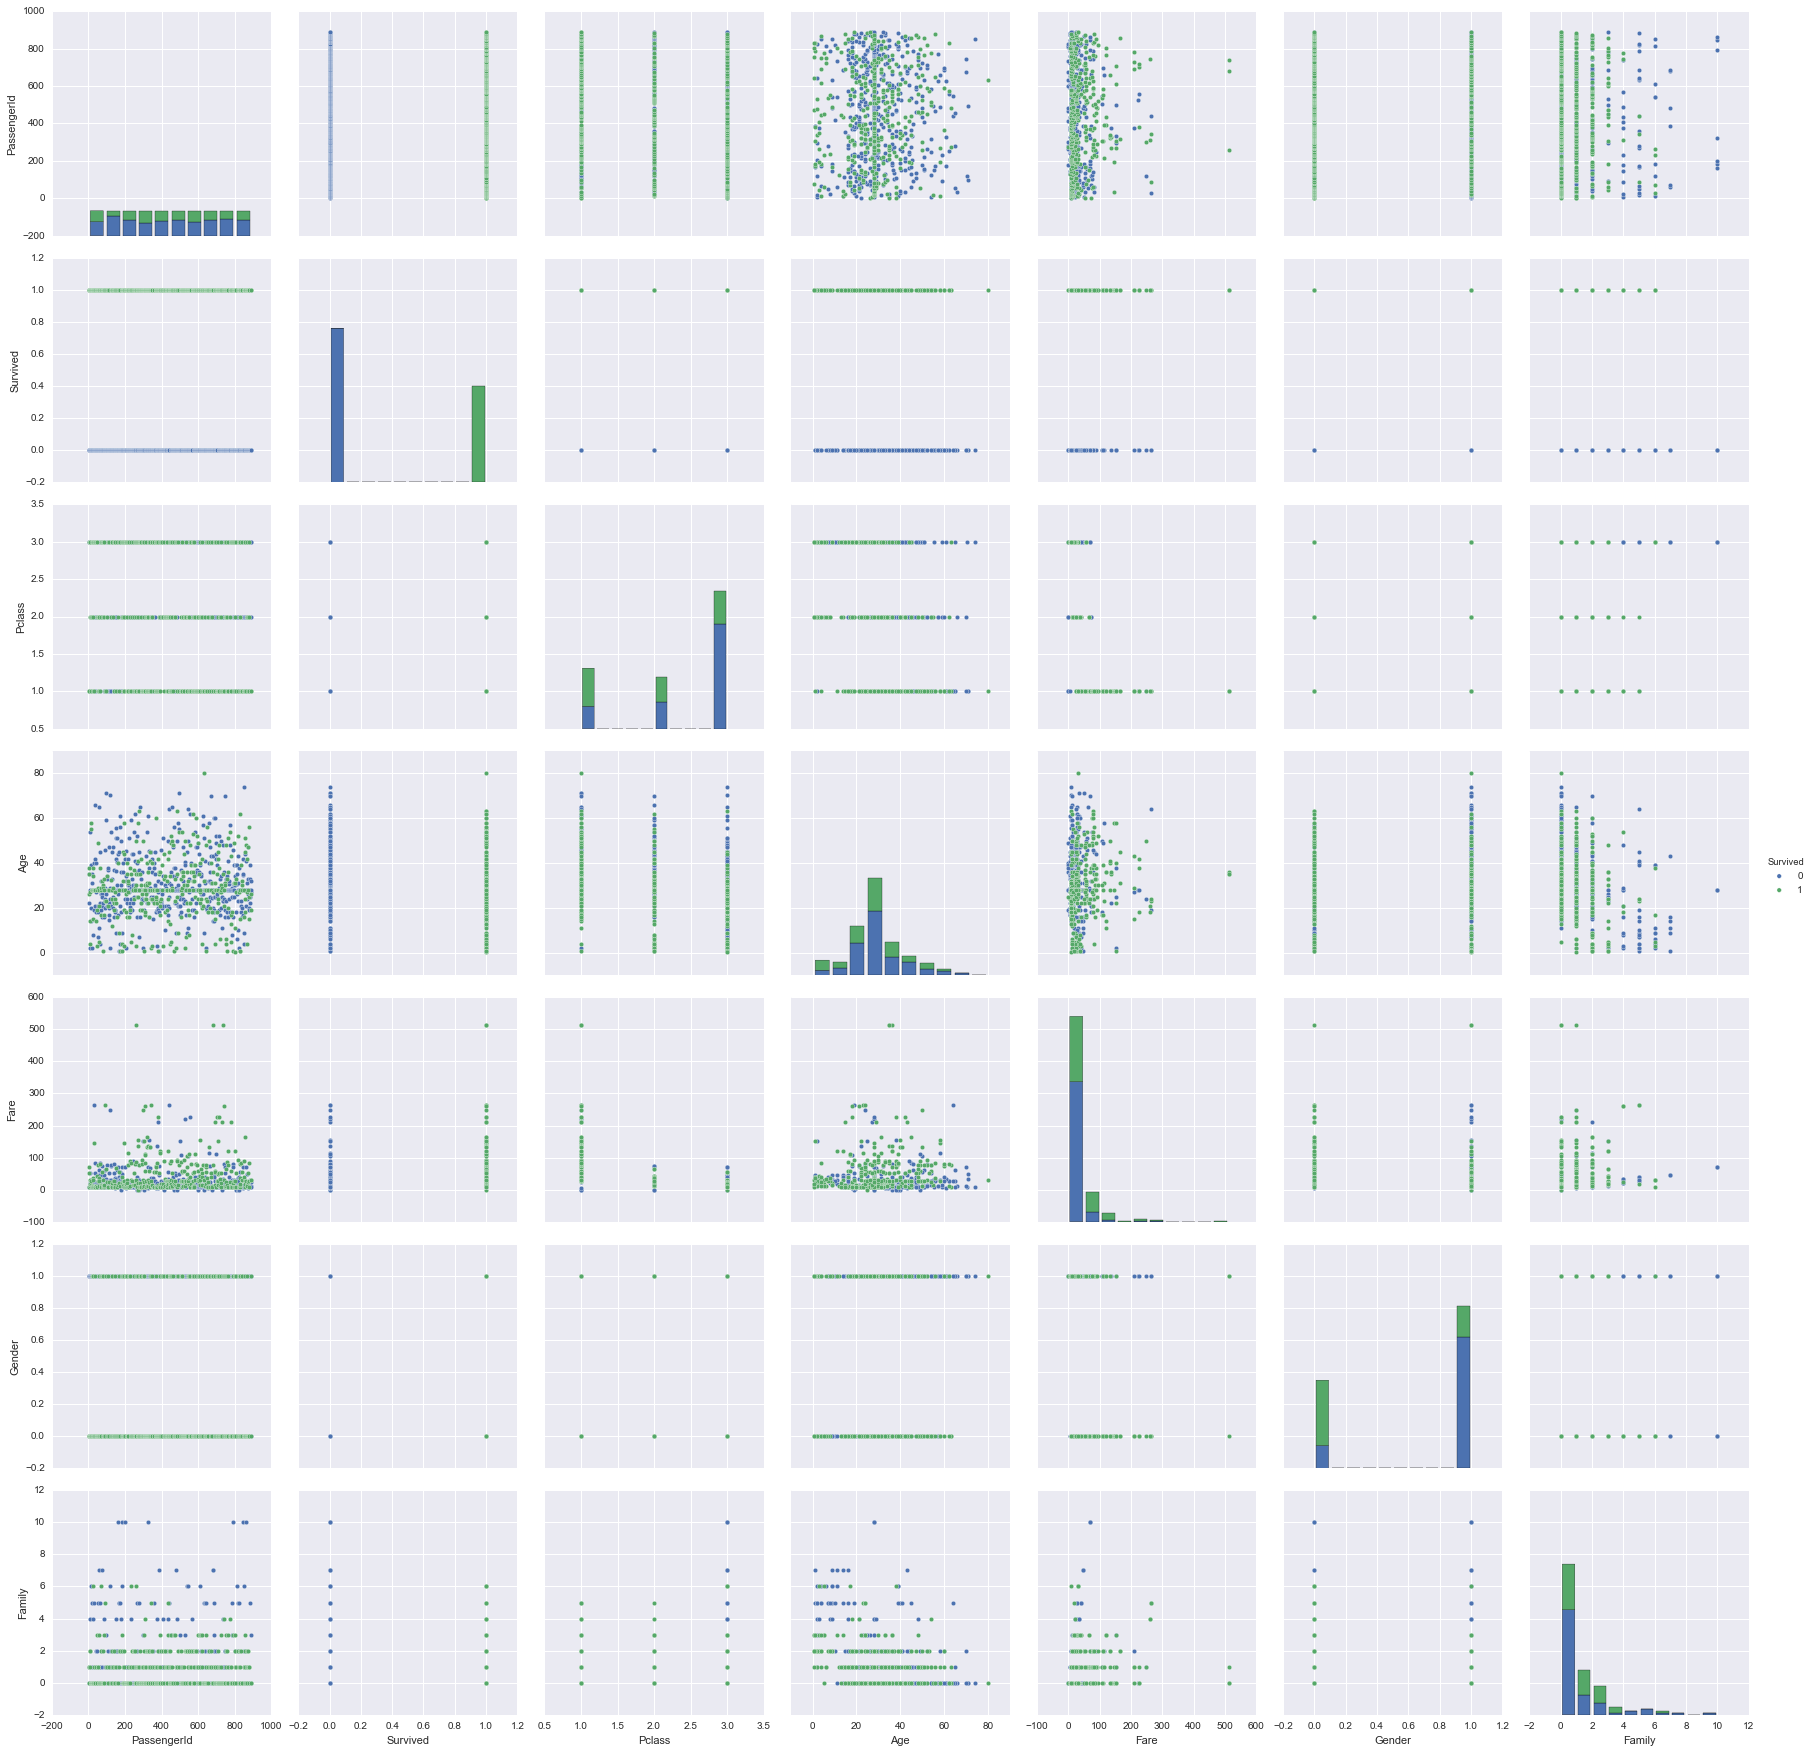

In [16]:
# lets explore full data with sns pairplots
sns.pairplot(train_data,hue='Survived',size=3.5)

In [17]:
# Logistic Regression 
logistic = linear_model.LogisticRegression()
X = train_data.drop(['PassengerId','Survived'],axis=1)
y = train_data['Survived']
logistic.fit(X,y)
logistic.score(X, y)

0.80134680134680136

In [18]:
X_test = test_df.drop(['PassengerId'],axis=1)

In [19]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 6 columns):
Pclass    418 non-null int64
Age       418 non-null float64
Fare      418 non-null float64
Cabin     91 non-null object
Gender    418 non-null int32
Family    418 non-null int64
dtypes: float64(2), int32(1), int64(2), object(1)
memory usage: 18.0+ KB


In [20]:
y_pred = logistic.predict(X_test)

ValueError: could not convert string to float: C105

In [21]:
# Random Forests 
random_forest = ensemble.RandomForestClassifier(n_estimators=100)
random_forest.fit(X,y)
y_pred = random_forest.predict(X_test)
random_forest.score(X,y)


ValueError: could not convert string to float: C105

In [ ]:
submission = pd.DataFrame({
        "PassengerId":test_df['PassengerId'],
        "Survived":y_pred
    })
submission.to_csv('titanic.csv',index=False)

In [ ]:
# Our Model just scored around using random forests 73 only for all new examples , We need to imprvove it much further... 
# Lets Consider to do feature scaling on widely distributed values
# we can see that age varies from 0.42 to 80 and Fare ranges from 0 to 512 , so lets scale them
# we will move the data into new df so the data originality of cleaned_df is not lost
featured_df = cleaned_df.copy()

# Scale Age
featured_df['Age'] = (featured_df['Age'] - featured_df['Age'].mean())/featured_df['Age'].std()

# Scale Fare
featured_df['Fare'] = (featured_df['Fare'] - featured_df['Fare'].mean())/featured_df['Fare'].std()

# Lets now work on cabin and try to convert into binary features , We are working on cabin as we assume that the passengers
# who are near to cabin which are close to life boats are likely to survive

# Fill all nan Values with U0 , Assuming it as Unknown Cabin U
featured_df['Cabin'] = featured_df['Cabin'].fillna('U0')
featured_df['CabinLetter'] = featured_df['Cabin'].map(lambda x:re.compile('([A-Za-z]+)').search(str(x)).group())


In [ ]:
# Simple plot to understand how the passengers survived based on Cabin, As we have many unknown values for cabin we got 
# more values at the end for (U,0) and (U,1) from this too we can see that most passengers who cabin number
# is unknown didn't survived.  And out out the known cabins Passengers in Cabin B are most likely to survive compared to others. 

plt.figure(figsize=(12,3))
featured_df[['CabinLetter','Survived']].groupby(by=['CabinLetter','Survived']).size().plot(kind='bar')

In [ ]:
# As we normalized and scaled the features already these plots doesnt make much sense now, but will be helpful just to know 
# how the dat ais distributed among the passengers
with sns.axes_style('white'):
    plt.figure(figsize=(25,5))
    plt.subplot(1,3,1)
    sns.distplot(cleaned_df['Age'])
    plt.subplot(1,3,2)
    sns.distplot(cleaned_df['Fare'])
    plt.subplot(1,3,3)
    sns.distplot(cleaned_df['Family'])

In [ ]:
# Now lets create Binary Features for Cabin 
featured_df = pd.concat([featured_df,pd.get_dummies(featured_df['CabinLetter']).rename(columns=lambda x: 'Cabin_' + str(x))],axis=1)

In [ ]:
featured_df.info()

In [ ]:
# ok now drop unnecessary columns from data typically the ones which are objects
train_data = featured_df.drop(['Name','SibSp','Parch','Ticket','Cabin','Embarked','CabinLetter','Sex'], axis=1).copy()

In [ ]:
def feature_update(featured_df):
    # Our Model just scored around using random forests 73 only for all new examples , We need to imprvove it much further... 
    # Lets Consider to do feature scaling on widely distributed values
    # we can see that age varies from 0.42 to 80 and Fare ranges from 0 to 512 , so lets scale them
    # we will move the data into new df so the data originality of cleaned_df is not lost
#     df = cleaned_df.copy()

    # Scale Age
    featured_df['Age'] = (featured_df['Age'] - featured_df['Age'].mean())/featured_df['Age'].std()

    # Scale Fare
    featured_df['Fare'] = (featured_df['Fare'] - featured_df['Fare'].mean())/featured_df['Fare'].std()

    # Lets now work on cabin and try to convert into binary features , We are working on cabin as we assume that the passengers
    # who are near to cabin which are close to life boats are likely to survive

    # Fill all nan Values with U0 , Assuming it as Unknown Cabin U
    featured_df['Cabin'] = featured_df['Cabin'].fillna('U0')
    featured_df['CabinLetter'] = featured_df['Cabin'].map(lambda x:re.compile('([A-Za-z]+)').search(str(x)).group())
    
    # Now lets create Binary Features for Cabin 
    featured_df = pd.concat([featured_df,pd.get_dummies(featured_df['CabinLetter']).rename(columns=lambda x: 'Cabin_' + str(x))],axis=1)
    
    return featured_df
    

In [ ]:
test_data = feature_update(test_df).drop(['Cabin','CabinLetter'], axis=1)
# train_data = featured_df.drop(['Name','SibSp','Parch','Ticket','Cabin','Embarked','CabinLetter','Sex'], axis=1).copy()#.info()

In [ ]:
# there in no Cabin T in test data so lets add that column
test_data['Cabin_T'] = 0

In [ ]:
(test_data.columns, train_data.columns)

In [ ]:
X = train_data.drop(['PassengerId','Survived'],axis=1)
y = train_data['Survived']
X_test = test_data.drop(['PassengerId'],axis=1)

random_forest = ensemble.RandomForestClassifier(n_estimators=200)
random_forest.fit(X,y)
y_pred = random_forest.predict(X_test)
random_forest.score(X,y)
# X_test.info()

In [ ]:
submission = pd.DataFrame({
        "PassengerId":test_df['PassengerId'],
        "Survived":y_pred
    })
submission.to_csv('titanic.csv',index=False)

In [ ]:
# Ok this submission scored 0.74163, which is a very little improvement to previous model , thats ok .. but not better than graphlab model 
# Lets try to apply more binary features on Embarked, and Also may be ticket number, Name etc... 

# But before that lets clean the notebook and define functions for reuse and for cleaning 